In [1]:
import os
import sys

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from core.extractor import (
    ConceptFusionFeatureExtractor,
    GroundedSAMInstanceExtractor,
    LSegFeatureExtractor,
    MaskRCNNMaskExtractor,
    RandomSAMFeatureExtractor,
    SAMMaskExtractor,
)
from core.extractor.utils import get_kmeans_labels, show_mask

In [3]:
sam_ckpt = "/home/quanta/Models/SAM/sam_vit_h_4b8939.pth"
sam_type = "vit_h"
clip_type = "ViT-B/32"  # this is the clip model used by clip-glass and DeCap
clip_download_root = "/home/quanta/.cache/clip"
lseg_ckpt = "/home/quanta/Models/LSeg/lseg_minimal_e200.ckpt"
grounding_dino_config_pth = "../examples/grounding_dino_config/GroundingDINO_SwinT_OGC.py"
grounding_dino_ckpt = "/home/quanta/Models/GroundingDINO/groundingdino_swint_ogc.pth"
ram_ckpt = "/home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth"
sam_hq_ckpt = "/home/quanta/Models/SAM_HQ/sam_hq_vit_h.pth"
mask_rcnn_ckpt = '/home/quanta/Models/scannet_mask_rcnn/model_0454999.pth'

In [4]:
img_path = '/home/quanta/Datasets/ScanNet/scans/scene0000_00/data/color/0.jpg'
img = Image.open(img_path)

In [5]:
device = 'cuda:0'

In [6]:
# extractor = MaskRCNNMaskExtractor(mask_rcnn_ckpt=mask_rcnn_ckpt, device=device)
extractor = MaskRCNNMaskExtractor(mask_rcnn_ckpt=None, device=device)
torch.cuda.empty_cache()
extractor.load_model()

In [7]:
%%time
results = extractor.extract(img)
masks = extractor.get_masks(results)

CPU times: user 362 ms, sys: 56.7 ms, total: 418 ms
Wall time: 271 ms


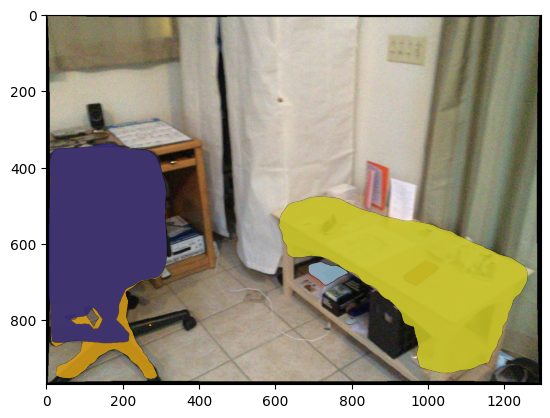

In [8]:
# plt.figure(figsize=(10, 10))
plt.imshow(img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

In [9]:
extractor = LSegFeatureExtractor(lseg_ckpt=lseg_ckpt, device=device)
torch.cuda.empty_cache()
extractor.load_model()

In [10]:
%%time
results = extractor.extract(img)
feats = extractor.get_feats(results)

CPU times: user 231 ms, sys: 9.4 ms, total: 241 ms
Wall time: 88.7 ms


In [11]:
print(results.keys(), feats.shape)

dict_keys(['feats']) torch.Size([240, 320, 512])


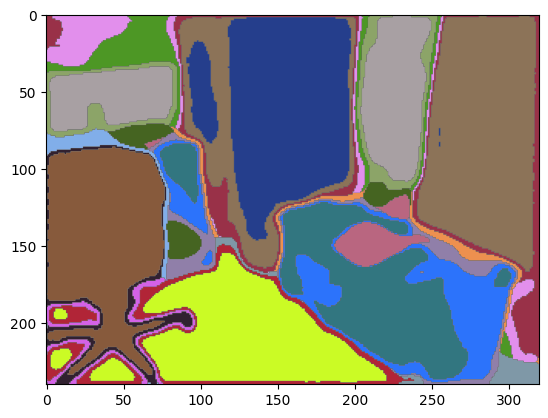

In [12]:
k=20
labels = get_kmeans_labels(k, feats)
for i in range(k):
    mask = labels == i
    show_mask(mask, plt.gca(), random_color=True)

In [13]:
extractor = ConceptFusionFeatureExtractor(
    sam_type=sam_type,
    sam_ckpt=sam_ckpt,
    clip_type=clip_type,
    clip_download_root=clip_download_root,
    weaken_background=True,
    weaken_factor=0.01,
    extend_ratio=1.0,
    global_weight=1.0,
    temperature=1.0,
    device=device,
)
torch.cuda.empty_cache()
extractor.load_model()

In [14]:
%%time
results = extractor.extract(img)
feats = extractor.get_feats(results)

CPU times: user 20.4 s, sys: 6.16 ms, total: 20.5 s
Wall time: 5.29 s


In [15]:
print(results.keys(), feats.shape)

dict_keys(['masks', 'boxes', 'global_feat', 'regional_feats', 'softmax_scores', 'H', 'W']) torch.Size([968, 1296, 512])


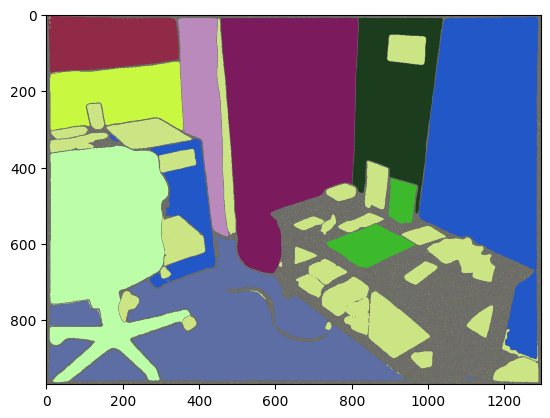

In [16]:
k=20
labels = get_kmeans_labels(k, feats)
for i in range(k):
    mask = labels == i
    show_mask(mask, plt.gca(), random_color=True)

In [17]:
extractor = SAMMaskExtractor(
    sam_type=sam_type,
    sam_ckpt=sam_ckpt,
    device=device,
)
torch.cuda.empty_cache()
extractor.load_model()

In [18]:
%%time
results = extractor.extract(img)
masks = extractor.get_masks(results)

CPU times: user 4.54 s, sys: 2.07 ms, total: 4.54 s
Wall time: 4.54 s


In [19]:
import sys

extractor.save(results, '../temp')

In [20]:
%%sh
ls -lah ../ | grep temp # 5.8 MB good!

-rw-r--r--  1 quanta quanta 5.8M  9月12日 14:18 temp
-rw-r--r--  1 quanta quanta 7.6K  9月 7日 23:24 temp.py


In [21]:
print(masks.shape, masks.dtype)

torch.Size([88, 968, 1296]) torch.bool


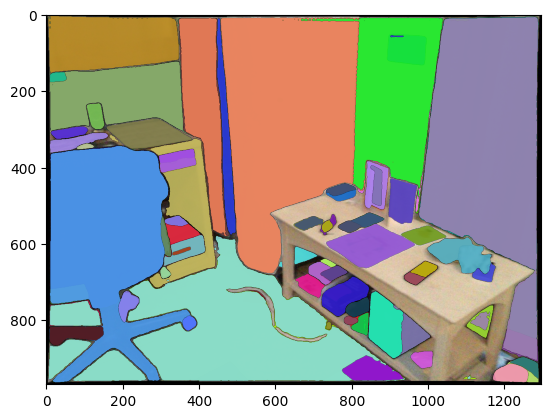

In [22]:
# plt.figure(figsize=(10, 10))
plt.imshow(img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

In [23]:
extractor = RandomSAMFeatureExtractor(
    sam_type=sam_type,
    sam_ckpt=sam_ckpt,
    device=device,
    feat_dim=128,
)
torch.cuda.empty_cache()
extractor.load_model()

In [24]:
%%time
results = extractor.extract(img)
feats = extractor.get_feats(results)

CPU times: user 8.56 s, sys: 0 ns, total: 8.56 s
Wall time: 5.05 s


In [25]:
print(feats.shape)

torch.Size([968, 1296, 128])


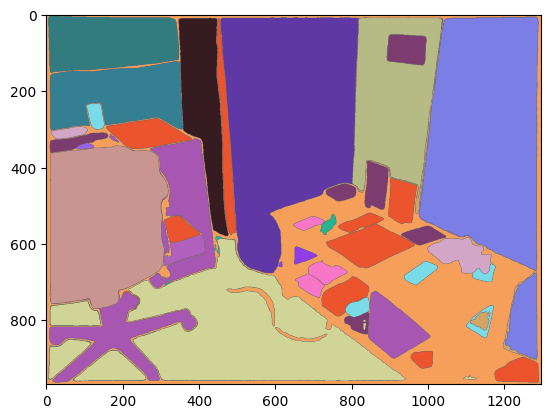

In [26]:
k=20
labels = get_kmeans_labels(k, feats)
for i in range(k):
    mask = labels == i
    show_mask(mask, plt.gca(), random_color=True)

In [27]:
extractor=GroundedSAMInstanceExtractor(
    ram_ckpt=ram_ckpt,
    grounding_dino_config_pth=grounding_dino_config_pth,
    grounding_dino_ckpt=grounding_dino_ckpt,
    sam_hq_ckpt=sam_hq_ckpt,
    device=device,
)
torch.cuda.empty_cache()
extractor.load_model()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 30524. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
/home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth
--------------
load checkpoint from /home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth
vit: swin_l
final text_encoder_type: bert-base-uncased
<All keys ma

In [28]:
%%time
results = extractor.extract(img)
masks = extractor.get_masks(results)

CPU times: user 1.07 s, sys: 18 ms, total: 1.09 s
Wall time: 609 ms


In [29]:
print(masks.shape, masks.dtype)

torch.Size([9, 968, 1296]) torch.bool


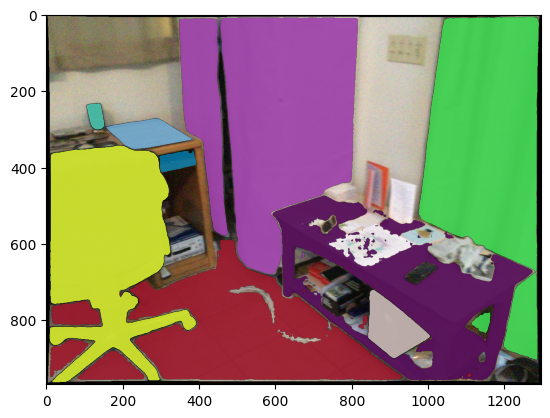

In [30]:
# plt.figure(figsize=(10, 10))
plt.imshow(img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

In [31]:
import cv2

In [32]:
(cv2.imread(img_path) == np.array(img)[:, :, ::-1]).mean()

1.0